#Explainability

Import the libraries necessary to analize data

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import shap
from lime.lime_tabular import LimeTabularExplainer
from aix360.metrics import faithfulness_metric, monotonicity_metric
from imblearn.under_sampling import RandomUnderSampler


In [233]:
dt = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df = dt.copy(deep = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute involve_killing

In [234]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [235]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [236]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

In [237]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   187534 non-null  float64
 1   longitude                  187534 non-null  float64
 2   congressional_district     187534 non-null  int64  
 3   avg_age_participants       187534 non-null  float64
 4   n_participants_child       187534 non-null  int64  
 5   n_participants_teen        187534 non-null  int64  
 6   n_females                  187534 non-null  float64
 7   n_killed                   187534 non-null  float64
 8   n_injured                  187534 non-null  float64
 9   n_arrested                 187534 non-null  float64
 10  n_unharmed                 187534 non-null  float64
 11  n_participants             187534 non-null  float64
 12  povertyPercentage          187534 non-null  float64
 13  candidatevotes             18

In [238]:

df.drop(columns=['latitude', 'longitude', 'n_killed', 'n_injured', 'n_unharmed', 'candidatevotes', 'totalvotes', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage'], axis=1,inplace=True)


In [239]:
label = df.pop('involve_killing')

We partitioned the dataset into training, validation, and test sets using a 70/15/15 split. Additionally, by merging the training and validation sets, we established a development set, comprising 85% of the data, since certain models do not necessitate validation.

In [240]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.15,random_state=10, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_trvl, y_trvl, test_size=0.18,random_state=10, stratify=y_trvl)

In [241]:
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

involve_killing
0    0.5
1    0.5
Name: proportion, dtype: float64


Used to summarize the data to only "K" centroids, since executing shap against the whole dataset is prohibitive computationally

In [242]:
#TODO change K
K = 10
background_summary = shap.kmeans(X_trvl_undersample, K) #background data

Lime intialization

In [243]:
explainer_lime = LimeTabularExplainer(np.array(X_trvl_undersample), feature_names=X_train.columns, class_names=["No-killing", "Killing"],training_labels=y_trvl_undersample,mode="classification",verbose=True)

Explainability models metrics

In [244]:
def explain_lime(explaination,index,model):
    le = explaination.local_exp[1]

    m = explaination.as_map()
    x = X_test.values[index]
    print(x)
    coefs = np.zeros(x.shape[0])

    for v in le:
        coefs[v[0]] = v[1]


    base = np.zeros(x.shape[0])

    print("Faithfulness: ", faithfulness_metric(model, x, coefs, base))
    print("Monotonity: ", monotonicity_metric(model, x,coefs, base))


In [245]:
def explain_shap_metrics(shap_values,model,index):
    predicted_class = model.predict(X_test.values[index].reshape(1,-1))[0]
    x = X_test.values[index]
    base = np.zeros(x.shape[0])
    print("Faithfulness: ", faithfulness_metric(model, x, shap_values[predicted_class][0], base))
    print("Monotonity: ", monotonicity_metric(model, x, shap_values[predicted_class][0], base))

## Random Forest

import libraries for random forest

In [246]:
from sklearn.ensemble import RandomForestClassifier
rd_fr = RandomForestClassifier(n_estimators=64, 
                             criterion='entropy',
                             max_features="log2",
                             max_depth=5, 
                             min_samples_split=2,
                             min_samples_leaf=4,
                             bootstrap=True) 

We run the classifier and compute the perfomance scores.

In [247]:
rd_fr.fit(X_trvl_undersample,y_trvl_undersample)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       min_samples_leaf=4, n_estimators=64)

Explain random forest with shap

In [248]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rd_fr)
explain_tree = explainer(X_test[0:20])
shap_values_tree = explainer.shap_values(X_test[0:20])
shap_interaction_values_tree = explainer.shap_interaction_values(X_test.iloc[0:20]) 

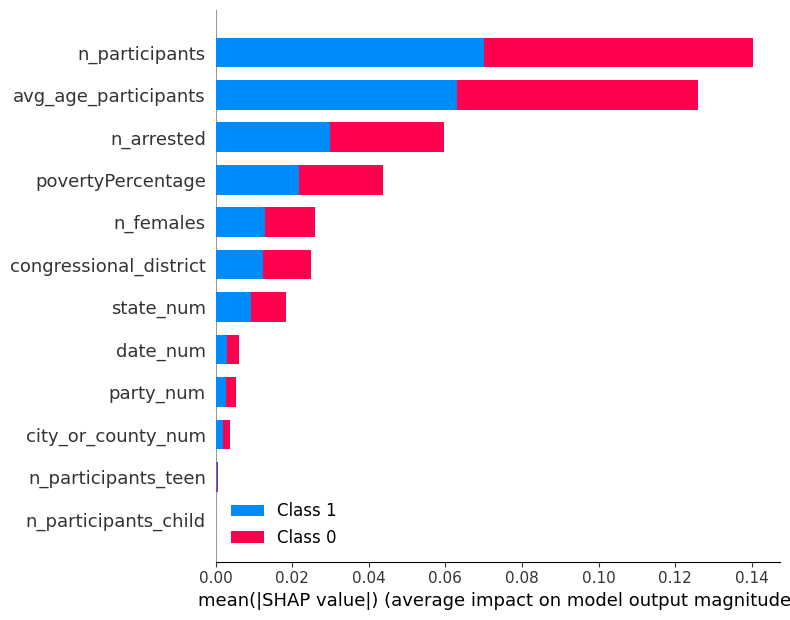

In [249]:
shap.summary_plot(shap_values_tree, X_test[0:20])

In [250]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_tree[0], X_test[0:20])

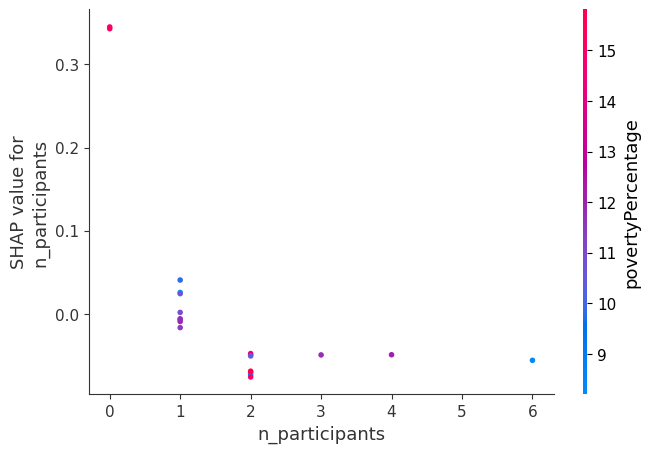

In [251]:
shap.dependence_plot("n_participants", shap_values_tree[0], X_test[0:20])

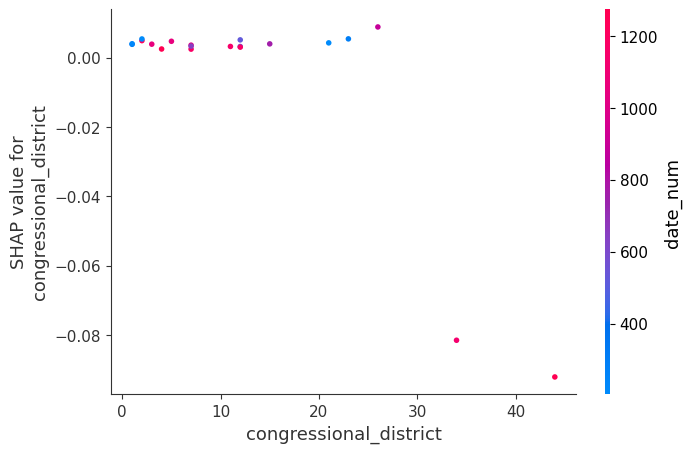

In [252]:
shap.dependence_plot("congressional_district", shap_values_tree[0], X_test[0:20])

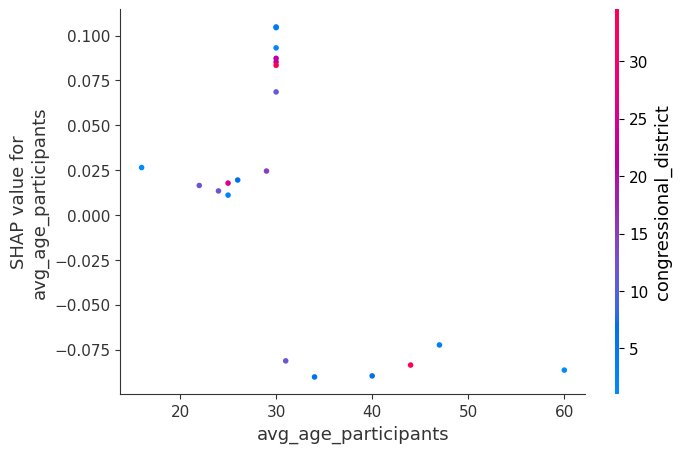

In [253]:
shap.dependence_plot("avg_age_participants", shap_values_tree[0], X_test[0:20])

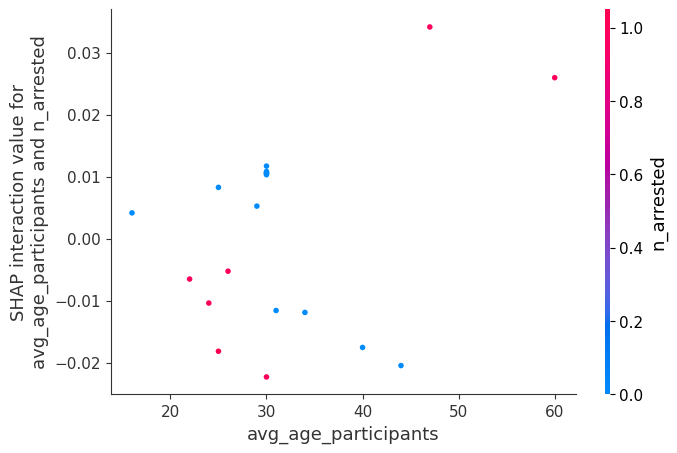

In [254]:
shap.dependence_plot(
    ("avg_age_participants", "n_arrested"),
    shap_interaction_values_tree[0], X_test.iloc[0:20]
)

LABEL: 1
Predicted LABEL: [1]
ROW: 0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


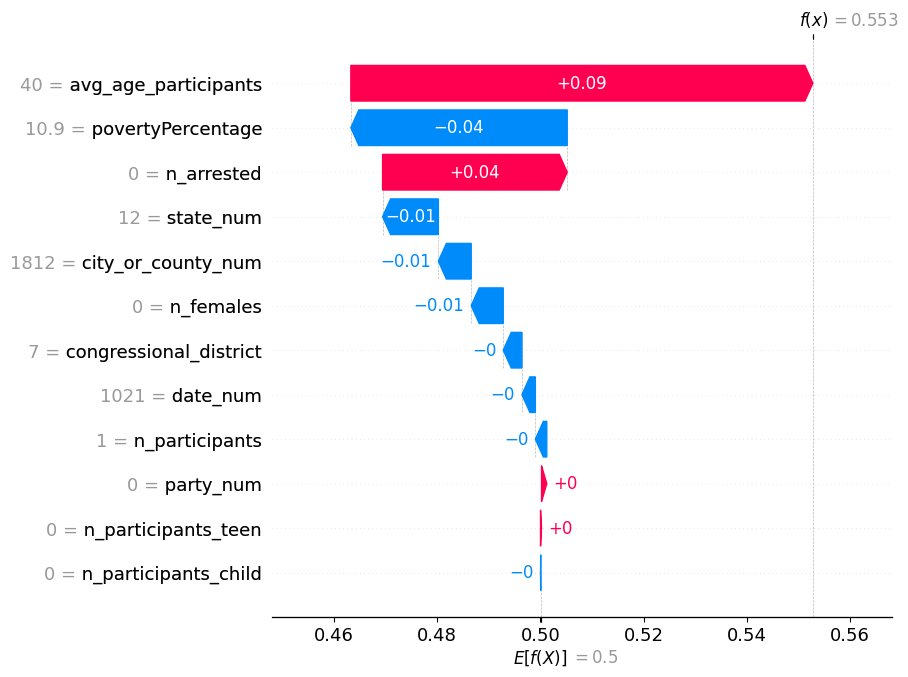

In [255]:
# visualize the first prediction's explanation
print("LABEL:",y_test.iloc[0])
predicted_class = rd_fr.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",0)

id_to_explain = 0                  
output_to_explain = 1
shap.plots.waterfall(explain_tree[id_to_explain,:,output_to_explain],max_display=15)



For this instance we can see that 6 features (n_participants_child,n_participants_teen,date_num,state_num,city_or_county_num,party_num) are not helpful to classify this row with index 0.
1) n_females = 0, reduces the chances of having iskilling equal to 1 (1%)
2) povertyPercentage = 9.8%, lower than the mean value (12.0%) but still impactful to classify the row, it increases the probability of having iskilling equal to 1 by 1%
3) winning_party_percentage = 0.818, that further increases the percentage by 2% towards the class 1 for isKilling
4) n_unharmed = 1, decreases the probabilty of having a dead person by 3%. This is understandable since the n_participants drops to 1, knowing that the other one is not dead and the fact that n_killed is linearly calculable from the other features
5) Congressional_district = 7, moves the probability towards 1 by 4%. Since the cities with this congressional district have high rate of homicides (Probable caused by the fact that ???)
6) avg_age_participants = 21, increases the probability by 5%, the number of records that have at least a person killed is 25% (1/4 of records). In this way we can see why it pushes the probability towards the value "1".
7) n_participants = 2, increases by 6% the probability of having a killed person. This because the number of records with 2 participants and having a dead person are 27%.
8) n_injured = 0, since isKilling can be linearly calculated thanks to this value, having it at 0 boosts the classifier towards the iskilling = 1.
Those combined proabibilities gives probability 0.41 that the istance will be classified as 1 and 0.59 to be classified as 0.

In [256]:
dt[dt["n_females"] == 0]

date     state         city_or_county   latitude   longitude  \
0      2016-01-14  maryland                 Severn  39.121929  -76.708729   
1      2015-03-03  maryland  Anne Arundel (county)  39.119550  -76.708250   
2      2015-10-11  maryland              Annapolis  38.970123  -76.503304   
3      2014-11-14  maryland               Pasadena  39.135933  -76.543956   
4      2017-10-27    alaska                 Palmer  61.571858 -149.081115   
...           ...       ...                    ...        ...         ...   
187529 2015-04-29    hawaii                  Lihue  21.977000 -159.351000   
187530 2015-05-04    hawaii                   Puna  19.511800 -154.902000   
187531 2014-09-15    hawaii               Honolulu  21.331600 -157.920000   
187532 2014-11-18    hawaii            Kailua Kona  19.559100 -155.962000   
187533 2014-06-12    hawaii                Kahului  20.889200 -156.449000   

        congressional_district  avg_age_participants  n_participants_child  \
0                            3                  25.0                     0   
1                            3                  35.0                     0   
2                            4                  50.0                     0   
3                            3                  21.0                     0   
4                            0                  31.0                     0   
...                        ...                   ...                   ...   
187529                       2                  30.0                     0   
187530                       2                  30.0                     0   
187531                       1                  30.0                     0   
187532                       2                  30.0                     0   
187533                       2                  30.0                     0   

        n_participants_teen  n_females  ...  females_rate  minor_rate  \
0                         0        0.0  ...           0.0         0.0   
1                         0        0.0  ...           0.0         0.0   
2                         0        0.0  ...           0.0         0.0   
3                         0        0.0  ...           0.0         0.0   
4                         0        0.0  ...           0.0         0.0   
...                     ...        ...  ...           ...         ...   
187529                    0        0.0  ...           0.0         0.0   
187530                    0        0.0  ...           0.0         0.0   
187531                    0        0.0  ...           0.0         0.0   
187532                    0        0.0  ...           0.0         0.0   
187533                    0        0.0  ...           0.0         0.0   

        arrested_rate  survival_rate  winning_party_percentage killed_rate  \
0                 1.0            0.0                  0.631898         0.0   
1                 1.0            0.0                  0.595491         0.0   
2                 1.0            0.0                  0.701783         0.0   
3                 0.0            0.0                  0.595491         1.0   
4                 1.0            0.0                  0.503209         0.0   
...               ...            ...                       ...         ...   
187529            0.0            0.0                  0.757649         0.0   
187530            0.0            0.0                  0.757649         0.0   
187531            0.0            0.0                  0.512377         0.0   
187532            0.0            0.0                  0.757649         0.0   
187533            0.0            0.0                  0.757649         0.0   

        injured_rate killed_disp_per_district  injured_disp_per_district  \
0                0.0                 0.000000                        0.0   
1                0.0                 0.000000                        0.0   
2                0.0                 0.000000                        0.0   
3                0.0             

In [257]:
X_test.iloc[0]

congressional_district       7.0
avg_age_participants        40.0
n_participants_child         0.0
n_participants_teen          0.0
n_females                    0.0
n_arrested                   0.0
n_participants               1.0
povertyPercentage           10.9
date_num                  1021.0
state_num                   12.0
city_or_county_num        1812.0
party_num                    0.0
Name: 8886, dtype: float64

In [258]:
sorted(dt["state"].unique())[20]


'massachusetts'

In [259]:
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

In [260]:
mean_values = dt.groupby("congressional_district")["n_killed"].mean()
mean_values.sort_values(ascending=False)

congressional_district
45    0.833333
40    0.715847
44    0.686567
37    0.647619
43    0.622047
33    0.568396
34    0.563910
29    0.511883
49    0.506849
32    0.494774
38    0.491803
30    0.470313
42    0.446602
50    0.427083
39    0.402985
41    0.395604
28    0.393120
51    0.380952
36    0.372913
31    0.361409
53    0.360825
47    0.350877
35    0.339400
46    0.325000
14    0.297199
48    0.290323
15    0.288849
20    0.279945
6     0.278887
21    0.277154
5     0.273495
7     0.270530
13    0.269592
22    0.267442
52    0.264957
10    0.263283
12    0.263223
18    0.260849
11    0.257543
9     0.257410
8     0.253488
3     0.253314
4     0.248181
24    0.247844
1     0.244714
2     0.244443
23    0.241166
25    0.240974
16    0.225564
19    0.216954
26    0.201633
0     0.200548
27    0.198191
17    0.142463
Name: n_killed, dtype: float64

In [261]:
print(dt[dt["avg_age_participants"] == 21]["n_killed"].value_counts(True))


n_killed
0.0    0.732417
1.0    0.254813
2.0    0.010806
3.0    0.001572
4.0    0.000393
Name: proportion, dtype: float64


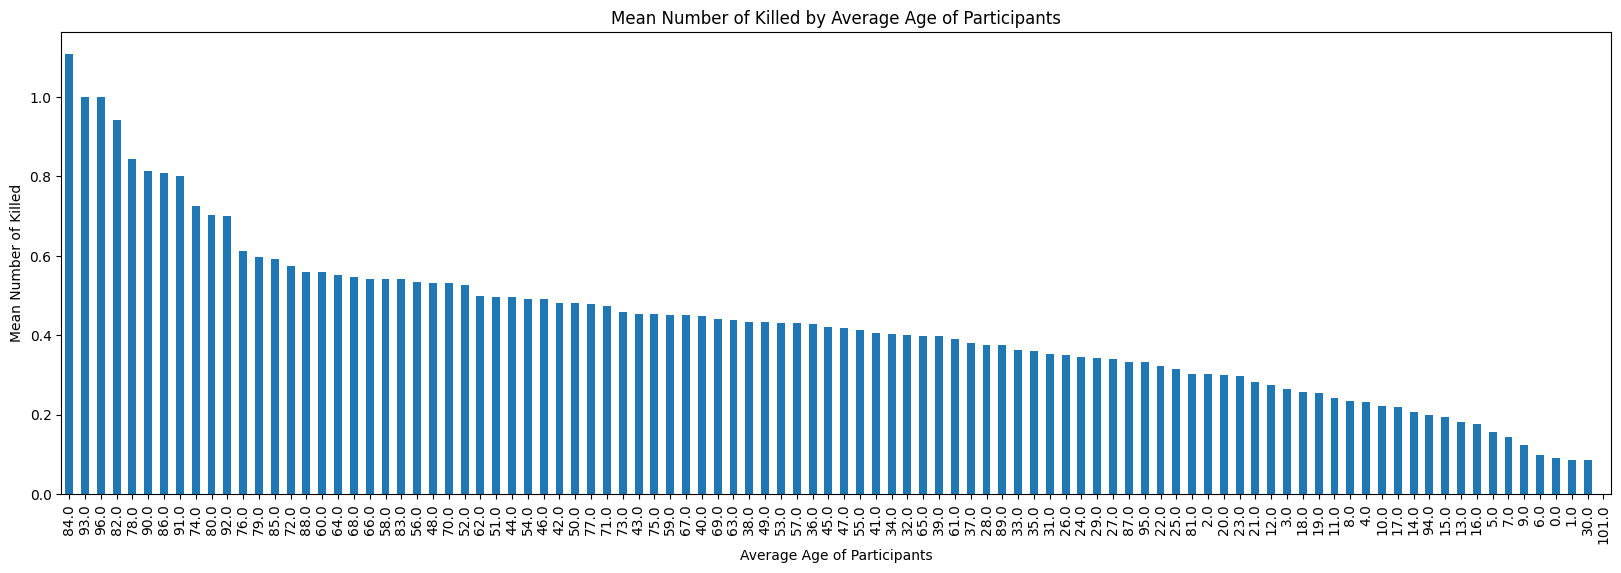

In [262]:

mean_values = dt.groupby("avg_age_participants")["n_killed"].mean()
mean_values_sorted = mean_values.sort_values(ascending=False)
# Plot the bar chart
mean_values_sorted.plot(kind='bar', figsize=(20, 6))
plt.title('Mean Number of Killed by Average Age of Participants')
plt.xlabel('Average Age of Participants')
plt.ylabel('Mean Number of Killed')
plt.show()

In [263]:
print(dt[dt["n_participants"] == 2]["n_killed"].mean())


0.36639077188120295


In [264]:
print(dt[dt["n_participants"] == 2]["n_killed"].value_counts(True))


n_killed
0.0    0.678270
1.0    0.277068
2.0    0.044661
Name: proportion, dtype: float64


In [265]:
explain_shap_metrics(shap_values_tree,rd_fr,0)

Faithfulness:  0.24952514086469432
Monotonity: 

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

 False


LABEL: 0
Predicted LABEL: [0]
ROW: 4


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


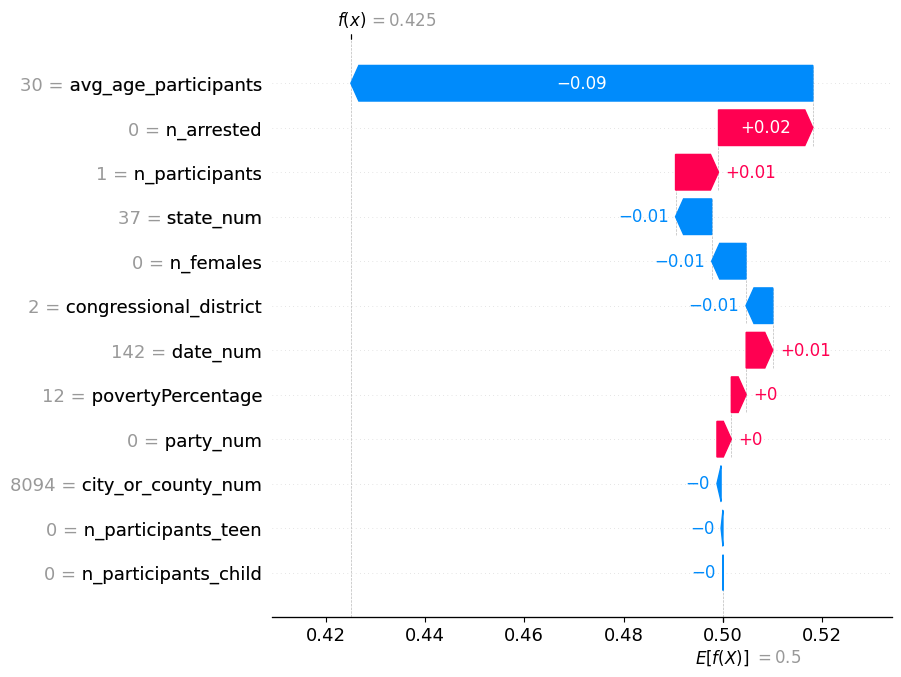

In [266]:
print("LABEL:",y_test.iloc[4])
predicted_class = rd_fr.predict(X_test.values[4].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",4)
id_to_explain = 4
output_to_explain = 1
shap.plots.waterfall(explain_tree[id_to_explain,:,output_to_explain],max_display=15)


n_participants_child,n_participants_teen,date_num,state_num,city_or_county_num,party_num

In [267]:
dt[dt["povertyPercentage"] > 20]["state"]
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

In [268]:
explain_shap_metrics(shap_values_tree,rd_fr,4)

Faithfulness:  -0.23089312896047914
Monotonity:  False


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

# Lime explain

In [269]:
instance_to_explain = X_test.iloc[0]
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer_lime.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


LABEL: 1
Intercept 0.5540348542702055
Prediction_local [0.46928449]
Right: 0.5528166530264705


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


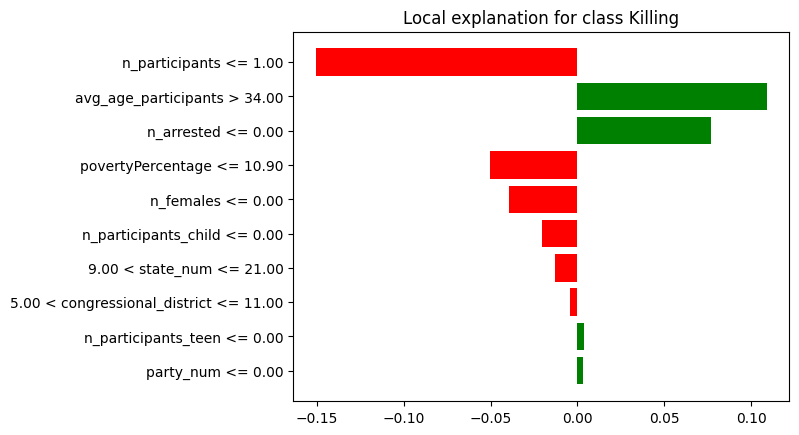

In [270]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [271]:
explain_lime(explanation_1,0,rd_fr)


[7.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.090e+01 1.021e+03 1.200e+01 1.812e+03 0.000e+00]
Faithfulness:  -0.4738403730379327
Monotonity:  False


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

In [272]:
instance_to_explain = X_test.iloc[4]
print("LABEL:",y_test.iloc[4])

explanation_0 = explainer_lime.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)



LABEL: 0


Intercept 0.5989878268832549
Prediction_local [0.39311138]
Right: 0.42503381178093386


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


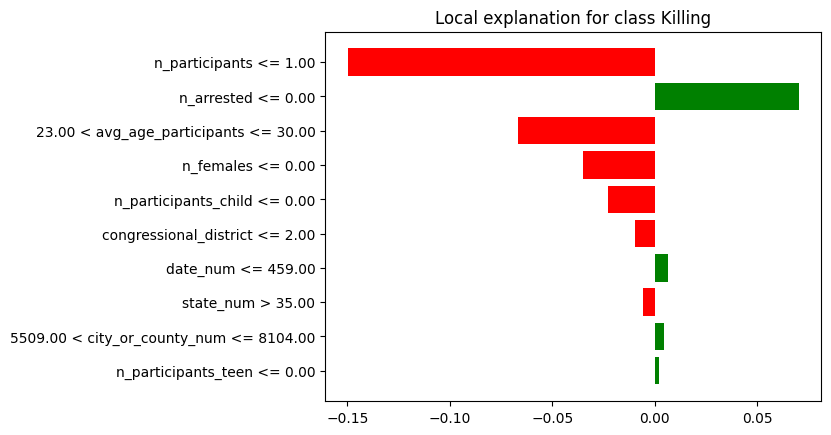

In [273]:
fig = explanation_0.as_pyplot_figure()
plt.show()

In [274]:
explain_lime(explanation_0,4,rd_fr)


[2.000e+00 3.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.200e+01 1.420e+02 3.700e+01 8.094e+03 0.000e+00]
Faithfulness:  0.6878742786818829
Monotonity:  False


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

## SVM

In [275]:
import scikitplot as skplt


We run the prediction on our test set.

In [276]:

from sklearn.svm import SVC
svc = SVC(kernel = "poly",max_iter = 1000,random_state=42,probability=True)
svc.fit(X_trvl_undersample,y_trvl_undersample)


Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


SVC(kernel='poly', max_iter=1000, probability=True, random_state=42)

Explain shap

In [277]:
# explain the model's predictions using SHAP
explainer_svc = shap.KernelExplainer(svc.predict_proba,background_summary)
explain_svc = explainer_svc(X_test[0:20])
shap_values_svc = explainer_svc.shap_values(X_test[0:20])

100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


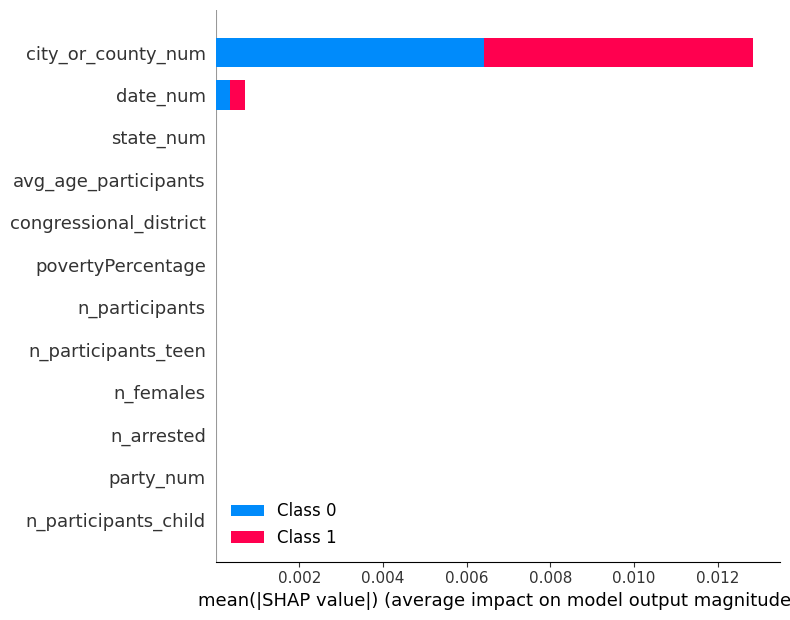

In [278]:
shap.summary_plot(shap_values_svc, X_test[0:20])

In [279]:
shap.initjs()
shap.force_plot(explainer_svc.expected_value[0], shap_values_svc[0], X_test[0:20])

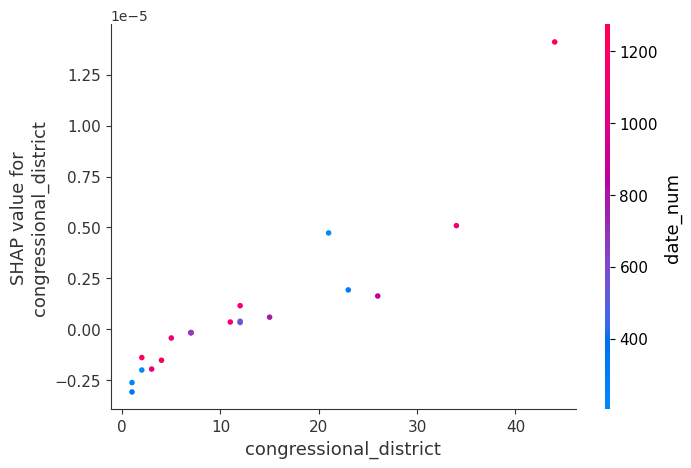

In [280]:
shap.dependence_plot("congressional_district", shap_values_svc[0], X_test[0:20])

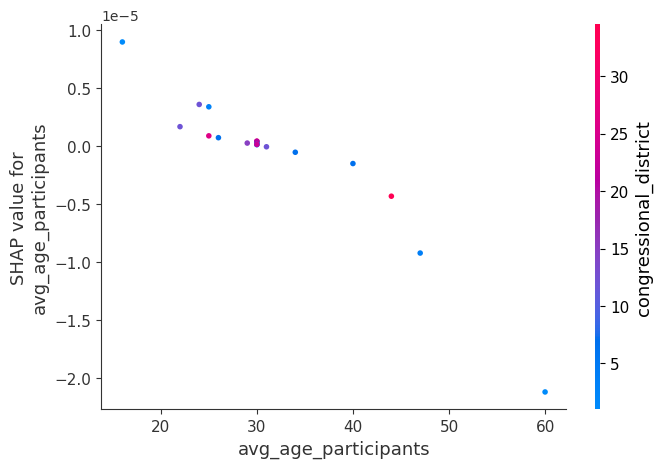

In [281]:
shap.dependence_plot("avg_age_participants", shap_values_svc[0], X_test[0:20])

LABEL: 1
Predicted LABEL: [1]
ROW: 0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


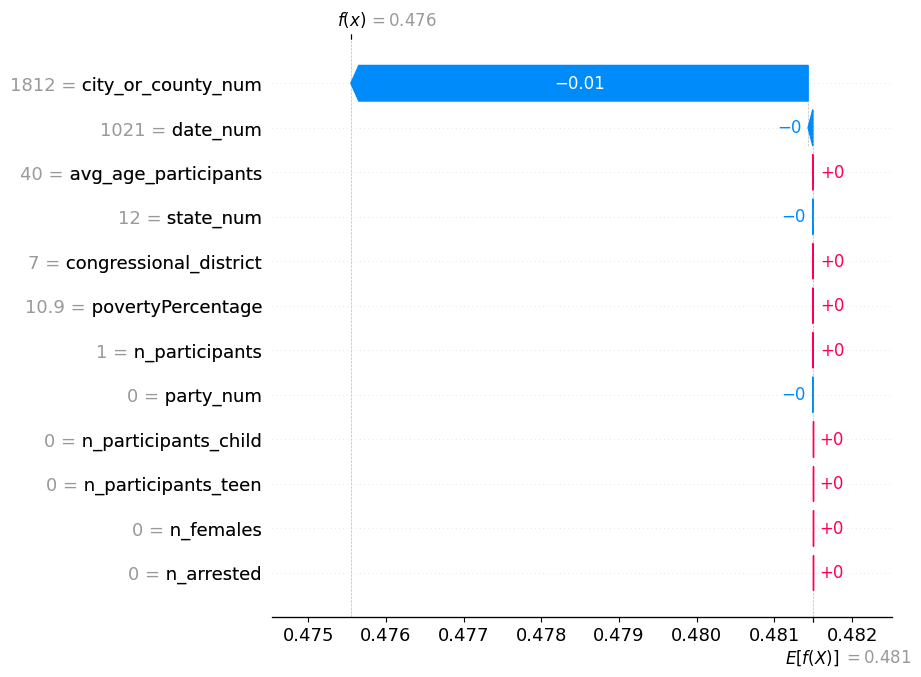

In [282]:
print("LABEL:",y_test.iloc[0])
predicted_class = rd_fr.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",0)
id_to_explain = 0
output_to_explain = 1
shap.plots.waterfall(explain_svc[id_to_explain,:,output_to_explain],max_display=15)


In [283]:
explain_shap_metrics(shap_values_tree,rd_fr,0)

Faithfulness:  0.24952514086469432
Monotonity:  False


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


LABEL: 0
Predicted LABEL: [0]
ROW: 4


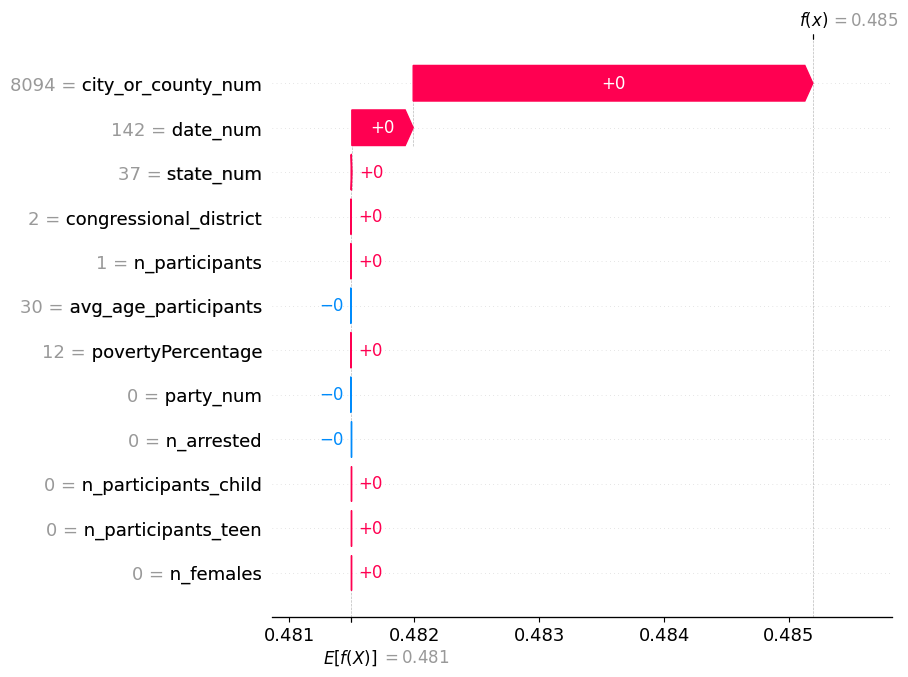

In [284]:
print("LABEL:",y_test.iloc[4])
predicted_class = rd_fr.predict(X_test.values[4].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",4)
id_to_explain = 4
output_to_explain = 1
shap.plots.waterfall(explain_svc[id_to_explain,:,output_to_explain],max_display=15)


In [285]:
explain_shap_metrics(shap_values_tree,rd_fr,4)

Faithfulness:  -0.23089312896047914
Monotonity:  False


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassif

Explain LIME

In [286]:
instance_to_explain = X_test.iloc[0]
predicted_class = rd_fr.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer_lime.explain_instance(instance_to_explain.values, svc.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


Predicted LABEL: [1]
LABEL: 1


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


Intercept 0.4838699537820807
Prediction_local [0.47528606]
Right: 0.4755471785151357


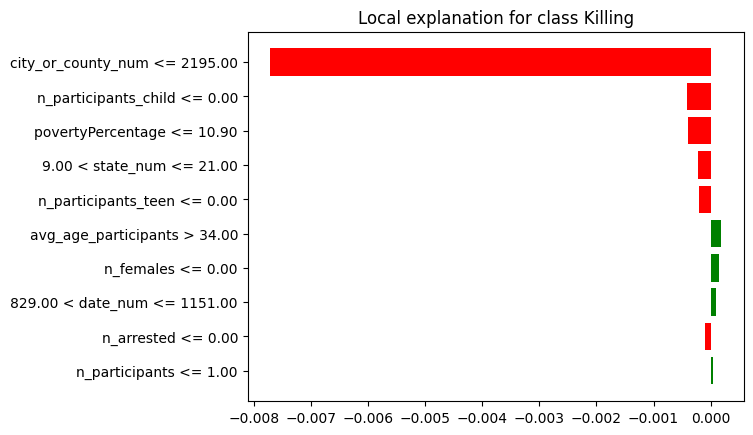

In [287]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [288]:
explain_lime(explanation_1,0,svc)

[7.000e+00 4.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.090e+01 1.021e+03 1.200e+01 1.812e+03 0.000e+00]
Faithfulness:  0.7141784088718625
Monotonity:  False


X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

In [289]:
instance_to_explain = X_test.iloc[4]
print("LABEL:",y_test.iloc[4])

explanation_0 = explainer_lime.explain_instance(instance_to_explain.values, svc.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)


LABEL: 0


X does not have valid feature names, but SVC was fitted with feature names


Intercept 0.48072953463865187
Prediction_local [0.48125468]
Right: 0.48519091492453437


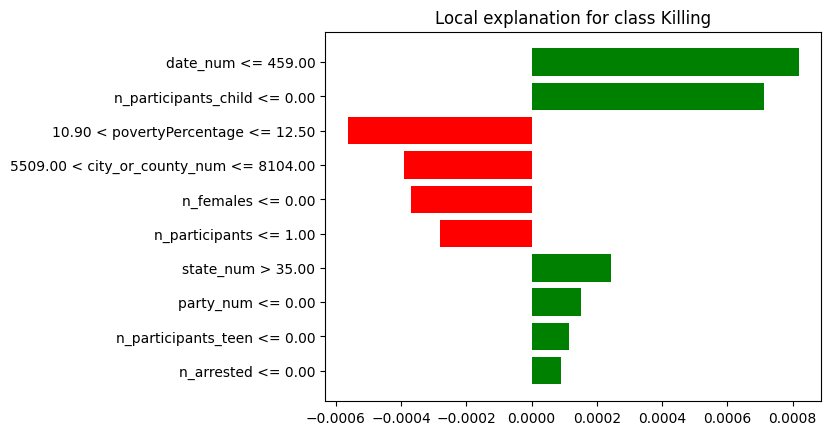

In [290]:
fig = explanation_0.as_pyplot_figure()
plt.show()

In [291]:
explain_lime(explanation_0,4,svc)

[2.000e+00 3.000e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.200e+01 1.420e+02 3.700e+01 8.094e+03 0.000e+00]
Faithfulness:  0.33311900904827707
Monotonity:  False


X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea